This is copy of kaggle notebook made by **Shahraiz**
Link to notebook: https://www.kaggle.com/shahraizanwar/age-based-text-classification-russian-corpus

**Prepare colab to work with Kaggle Data Sets.**

In [5]:
! pip install -q kaggle

In [6]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.9)


In [7]:
from google.colab import files

In [8]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"armankizatov","key":"9ec6bd9c97096b18d00bb9fbb00805a0"}'}

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  -----------------------------------------------  ------  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                                  429KB  2020-11-15 13:41:13           4504  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                           353MB  2020-11-09 18:51:59           2400  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University          2MB  2020-11-16 06:04:17           1618  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates           199MB  2020-10-23 16:56:10            450  
etsc9287/2020-general-election-polls                    Election, COVID, and Demographic Data by Cou

In [12]:
!kaggle datasets download oldaandozerskaya/fiction-corpus-for-agebased-text-classification

 98% 500M/509M [00:06<00:00, 98.6MB/s]
100% 509M/509M [00:06<00:00, 76.6MB/s]


In [13]:
!unzip fiction-corpus-for-agebased-text-classification.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/adults_2382.txt    
  inflating: test/adults_2383.txt    
  inflating: test/adults_2384.txt    
  inflating: test/adults_2385.txt    
  inflating: test/adults_2386.txt    
  inflating: test/adults_2387.txt    
  inflating: test/adults_2388.txt    
  inflating: test/adults_2389.txt    
  inflating: test/children_1499.txt  
  inflating: test/children_1500.txt  
  inflating: test/children_1501.txt  
  inflating: test/children_1502.txt  
  inflating: test/children_1503.txt  
  inflating: test/children_1504.txt  
  inflating: test/children_1505.txt  
  inflating: test/children_1506.txt  
  inflating: test/children_1507.txt  
  inflating: test/children_1508.txt  
  inflating: test/children_1509.txt  
  inflating: test/children_1510.txt  
  inflating: test/children_1511.txt  
  inflating: test/children_1512.txt  
  inflating: test/children_1513.txt  
  inflating: test/children_1514.txt  
  inflating: test/ch

**Needed dependencies.**

In [14]:
# /content/fiction-corpus-for-agebased-text-classification.zip
import numpy as np
import pandas as pd
import random as rn
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import nltk
from nltk.corpus import stopwords

import seaborn as sns
import re

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.107.15.218:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.107.15.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.107.15.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Extracting description of data set.**

In [15]:
description_file = "/content/description.csv"
columns = ['file_name', 'book_title', 'author', 'age_rating', 'genres']
desc = pd.read_csv(description_file, encoding="utf-8", delimiter=';', names=columns)
desc.head()

,file_name,book_title,author,age_rating,genres
0,children_1.txt,Три четверти,Анна Красильщик,12,Детская проза|Детские книги
1,children_2.txt,Повести и рассказы,Аркадий Гайдар,12,Детская проза|Детские книги
2,children_3.txt,"Оленёнок Крапинка, или Бархатистый носик",Холли Вебб,6,Детская проза|Детские книги
3,children_4.txt,Сара и роль мечты,Холли Вебб,6,Детская проза|Детские книги
4,children_5.txt,Как Гитлер украл розового кролика,Джудит Керр,6,Детская проза|Детские книги


**Loading train&test data from directories**

In [16]:
train_directory = "/content/train/"
test_directory = "/content/test/"

def get_text(row):
    
    ## Find a file in train directory if not 
    ## found go to test directory
    
    try:
        f = open(train_directory + row['file_name'], "r")
        row['file_name'] = ' '.join(f.read().split())
        row['data'] = 'Train'
        return row
    
    except FileNotFoundError:
        
        f = open(test_directory + row['file_name'], "r")
        row['file_name'] = ' '.join(f.read().split())
        row['data'] = 'Test'
        return row
    

desc['data'] = 'All'
data = desc[['file_name','age_rating', 'data']].apply(get_text, axis=1)
data.columns = ['text', 'age', 'data']

data.head()

,text,age,data
0,Три четверти Анна Красильщик Анна Красильщик Т...,12,Train
1,Повести и рассказы Аркадий Петрович Гайдар Бол...,12,Train
2,"Оленёнок Крапинка, или Бархатистый носик Холли...",6,Train
3,Сара и роль мечты Холли Вебб Школа моей мечты!...,6,Train
4,Как Гитлер украл розового кролика Джудит Керр ...,6,Train


**Train Data**

In [17]:
train_data = data.query("data == 'Train'").reset_index(drop=True)
train_data.head()

,text,age,data
0,Три четверти Анна Красильщик Анна Красильщик Т...,12,Train
1,Повести и рассказы Аркадий Петрович Гайдар Бол...,12,Train
2,"Оленёнок Крапинка, или Бархатистый носик Холли...",6,Train
3,Сара и роль мечты Холли Вебб Школа моей мечты!...,6,Train
4,Как Гитлер украл розового кролика Джудит Керр ...,6,Train


**Test Data**

In [18]:
test_data = data.query("data == 'Test'").reset_index(drop=True)
test_data.head()

,text,age,data
0,Осколки счастья Валерий Тамазович Квилория Вал...,6,Test
1,"Три козявки, фиолетовый козёл и тётя Фрося Вал...",6,Test
2,Перепёлка и Воробей Валерий Тамазович Квилория...,6,Test
3,Часы и стрелки Валерий Тамазович Квилория Вале...,6,Test
4,Красотка пиявка Валерий Тамазович Квилория Вал...,6,Test


**Data distribution**

In [19]:
data_dist = data['data'].value_counts()
fig = go.Figure(go.Bar(x = data_dist.index, y = data_dist.values))

fig.update_layout(title_text="Data Distribution")
fig.show()

In [20]:
age_dist_train = train_data['age'].value_counts()
age_dist_test = test_data['age'].value_counts()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Train","Test")
)

fig.add_trace(
    go.Bar(x = age_dist_train.index, y = age_dist_train.values),
    col=1, row=1
)

fig.add_trace(
    go.Bar(x = age_dist_test.index, y = age_dist_test.values),
    col=2, row=1
)

fig.update_layout(title_text="Age Distribution")

In [21]:
bins = [0, 6, 12, 18]
labels = ['0-6','7-12','13-18']
binned_age_train = pd.cut(train_data['age'], bins=bins, labels=labels).value_counts()
binned_age_test = pd.cut(test_data['age'], bins=bins, labels=labels).value_counts()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Train","Test")
)

fig.add_trace(
    go.Bar(x = binned_age_train.index, y = binned_age_train.values),
    col=1, row=1
)

fig.add_trace(
    go.Bar(x = binned_age_test.index, y = binned_age_test.values),
    col=2, row=1
)

fig.update_layout(title_text="Binned Age Distribution")

**Data Preprocessing**

In [22]:
X_train = train_data['text'].copy()
y_train = pd.cut(train_data['age'], bins=bins, labels=labels).copy()

X_test = test_data['text'].copy()
y_test = pd.cut(test_data['age'], bins=bins, labels=labels).copy()

X_train.head()

0    Три четверти Анна Красильщик Анна Красильщик Т...
1    Повести и рассказы Аркадий Петрович Гайдар Бол...
2    Оленёнок Крапинка, или Бархатистый носик Холли...
3    Сара и роль мечты Холли Вебб Школа моей мечты!...
4    Как Гитлер украл розового кролика Джудит Керр ...
Name: text, dtype: object

**Cleaning**

In [23]:
import nltk
nltk.download("stopwords")
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
%%time
#from nltk.stem.snowball import SnowballStemmer
# import nltk
# nltk.download("stopwords")
# from nltk.tokenize import word_tokenize
#stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words('russian'))

def data_cleaner(text):
    
    text = re.sub(" \d+", " ", text)
    
    
    #removing stop words
    text = text.lower().split()
    text = " ".join([word for word in text if not word in stop_words])
    
    #Stemming
    #text = " ".join([stemmer.stem(w) for w in text])
    
    return text

#ps = PorterStemmer() 
# stop_words = set(stopwords.words('russian'))

X_train_cleaned = X_train.apply(data_cleaner)
X_test_cleaned = X_test.apply(data_cleaner)

X_train_cleaned.head()
X_test_cleaned.head()

CPU times: user 24.4 s, sys: 2.97 s, total: 27.4 s
Wall time: 27.9 s


**Tokenization**

In [27]:
length_dist = [len(x.split(" ")) for x in X_train]
plt.hist(length_dist)
plt.title("Sequence length distribution")
plt.show()

KeyboardInterrupt: ignored

In [28]:
%%time

vocab_size = 80000

tokenizer = Tokenizer(lower=False, num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_enc = tokenizer.texts_to_sequences(X_train)
X_test_enc = tokenizer.texts_to_sequences(X_test)

#vocab_size = len(tokenizer.word_index)+1
#exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
#print("max length of sentence: {}".format(max_length))
#print("\nExample:\n")
#print("Sentence:\n{}".format(X_train[exp_sen]))
#print("\nAfter tokenizing :\n{}".format(X_train_enc[exp_sen]))

KeyboardInterrupt: ignored

**Padding**

In [29]:
max_len = 10000

X_train_pd = pad_sequences(X_train_enc, padding='post', maxlen=max_len)
X_test_pd = pad_sequences(X_test_enc, padding='post', maxlen=max_len)

**Label Encoding**

In [30]:
encoding = {'0-6': 0,
            '7-12': 1,
            '13-18': 2}

labels = ['0-6', '7-12', '13-18']

y_train_enc = y_train.copy()
y_test_enc = y_test.copy()

y_train_enc.replace(encoding, inplace=True)
y_test_enc.replace(encoding, inplace=True)

**Model building and training**

In [31]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)



# hyper parameters
EPOCHS = 5
BATCH_SIZE = 256
embedding_dim = 16

with tpu_strategy.scope():
    model = tf.keras.Sequential([
        L.Embedding(vocab_size, embedding_dim, input_length=X_train_pd.shape[1]),
        L.Bidirectional(L.LSTM(64,return_sequences=True)),
        L.Conv1D(64,8),
        L.MaxPool1D(),
        L.Bidirectional(L.LSTM(64,return_sequences=True)),
        L.Conv1D(64,6),
        L.MaxPool1D(),
        L.Bidirectional(L.LSTM(64,return_sequences=True)),
        L.Conv1D(64,3),
        L.MaxPool1D(),
        #L.LSTM(64,return_sequences=True),
        #L.Conv1D(64,2),
        #L.GlobalMaxPooling1D(),
        L.Flatten(),
        L.Dropout(0.5),
        L.Dense(128, activation="relu"),
        L.Dropout(0.5),
        L.Dense(64, activation="relu"),
        L.Dropout(0.5),
        L.Dense(3, activation="softmax")
    ])


    model.compile(loss=SparseCategoricalCrossentropy(),
                  optimizer='adam',metrics=['accuracy']
                 )

model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.107.15.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.107.15.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10000, 16)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 10000, 128)        41472     
_________________________________________________________________
conv1d (Conv1D)              (None, 9993, 64)          65600     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4996, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4996, 128)         66048     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4991, 64)          49216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2495, 64)          0

In [32]:
history = model.fit(X_train_pd, y_train_enc, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/16 [==>...........................] - ETA: 2:19 - loss: 1.1295 - accuracy: 0.2402WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0059s vs `on_train_batch_end` time: 0.7382s). Check your callbacks.


16/16 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.4193WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0021s vs `on_test_batch_end` time: 0.1640s). Check your callbacks.


16/16 [==============================] - 60s 4s/step - loss: 1.1285 - accuracy: 0.4193 - val_loss: 0.8111 - val_accuracy: 0.6185
Epoch 2/5
16/16 [==============================] - 13s 796ms/step - loss: 0.9591 - accuracy: 0.5230 - val_loss: 0.6679 - val_accuracy: 0.6722
Epoch 3/5
16/16 [==============================] - 13s 796ms/step - loss: 0.8510 - accuracy: 0.5883 - val_loss: 0.6929 - val_accuracy: 0.7222
Epoch 4/5
16/16 [==============================] - 13s 801ms/step - loss: 0.7477 - accuracy: 0.6506 - val_loss: 0.5434 - val_accuracy: 0.7907
Epoch 5/5
16/16 [==============================] - 13s 800ms/step - loss: 0.6090 - accuracy: 0.7338 - val_loss: 0.4708 - val_accuracy: 0.7685


**Training history**

In [33]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

In [34]:
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

**Evaluation**

In [35]:
pred = model.predict_classes(X_test_pd[0:1000], batch_size=8)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


**Accuracy**

In [36]:
print('Accuracy: {}'.format(accuracy_score(pred, y_test_enc)))

Accuracy: 0.789


**Confusion Matrix**

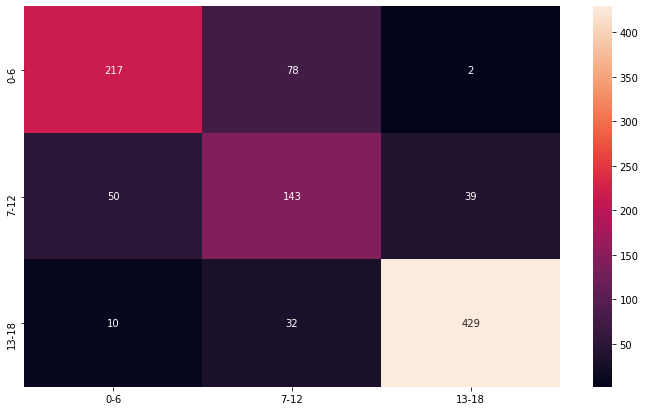

In [37]:
conf = confusion_matrix(y_test_enc, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

**Classification Report**

In [38]:
print(classification_report(y_test_enc, pred, target_names=labels))

              precision    recall  f1-score   support

         0-6       0.78      0.73      0.76       297
        7-12       0.57      0.62      0.59       232
       13-18       0.91      0.91      0.91       471

    accuracy                           0.79      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.79      0.79      0.79      1000

